# Gas-Phase Calculations
https://wwwbrr.cr.usgs.gov/projects/GWC_coupled/phreeqc/phreeqc3-html/phreeqc3-62.htm#50528271_44022

In [1]:
%pylab inline
import phreeqpython
import pandas as pd
pp = phreeqpython.PhreeqPython(database='phreeqc.dat')

Populating the interactive namespace from numpy and matplotlib


## Add Master, Solution Species and Phases by executing PHREEQC input code

In [21]:
pp.ip.run_string("""
SOLUTION_MASTER_SPECIES
N(-3)    NH4+           0.0     N
SOLUTION_SPECIES
NH4+ = NH3 + H+
        log_k           -9.252
        delta_h 12.48   kcal
        -analytic    0.6322    -0.001225     -2835.76
 
NO3- + 10 H+ + 8 e- = NH4+ + 3 H2O
        log_k           119.077
        delta_h -187.055        kcal
        -gamma    2.5000    0.0000
PHASES
NH3(g)
        NH3 = NH3
        log_k           1.770
        delta_h -8.170  kcal
""")

## Run Calculation

In [27]:
# add empty solution 1
solution1 = pp.add_solution({})
# equalize solution 1 with Calcite and CO2
solution1.equalize(['Calcite', 'CO2(g)'], [0,-1.5])

# create a fixed pressure gas phase
fixed_pressure = pp.add_gas({
    'CO2(g)': 0,
    'CH4(g)': 0,
    'N2(g)': 0,
    'H2O(g)': 0,
}, pressure=1.1, fixed_pressure=True)

# create a fixed volume gas phase
fixed_volume = pp.add_gas({
    'CO2(g)': 0,
    'CH4(g)': 0,
    'N2(g)': 0,
    'H2O(g)': 0,
}, volume=23.19, fixed_pressure=False, fixed_volume=True, equilibrate_with=solution1)

mmol = [1, 2, 3, 4, 8, 16, 32, 64, 125, 250, 500, 1000]

# instantiate result lists
fp_vol = []; fp_pres = []; fp_frac = []; fv_vol = []; fv_pres = []; fv_frac = []

for m in mmol:

    sol = solution1.copy()
    fp = fixed_pressure.copy()
    # equlibriate with solution
    sol.add('CH2O(NH3)0.07', m, 'mmol')
    sol.interact(fp)
    fp_vol.append(fp.volume)
    fp_pres.append(fp.pressure)
    fp_frac.append(fp.partial_pressures)

    sol.forget(); fp.forget() # clean up solutions after use
    
    sol = solution1.copy()
    fv = fixed_volume.copy()
    sol.add('CH2O(NH3)0.07', m, 'mmol')
    sol.interact(fv)
    fv_vol.append(fv.volume)
    fv_pres.append(fv.pressure)
    fv_frac.append(fv.partial_pressures)
    
    sol.forget(); fv.forget() # clean up solutions after use

## Total Gas Pressure and Volume

Text(0,0.5,'Volume, in liters)')

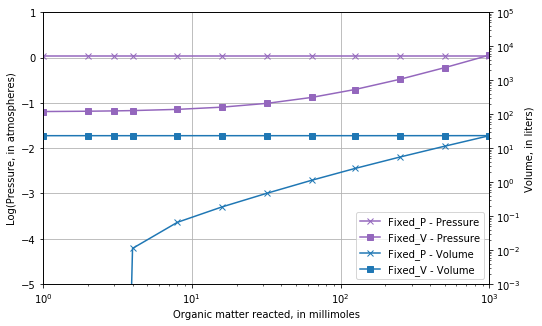

In [34]:
plt.figure(figsize=[8,5])

# create two y axes
ax1 = plt.gca()
ax2 = ax1.twinx()

# plot pressures
ax1.plot(mmol, np.log10(fp_pres), 'x-', color='tab:purple', label='Fixed_P - Pressure')
ax1.plot(mmol, np.log10(fv_pres), 's-', color='tab:purple', label='Fixed_V - Pressure')

# add dummy handlers for legend
ax1.plot(np.nan, np.nan, 'x-', color='tab:blue', label='Fixed_P - Volume')
ax1.plot(np.nan, np.nan, 's-', color='tab:blue', label='Fixed_V - Volume')

# plot volumes
ax2.plot(mmol, fp_vol, 'x-')
ax2.plot(mmol, fv_vol, 's-', color='tab:blue')

# set log scale to both y axes
ax2.set_xscale('log')
ax2.set_yscale('log')

# set axes limits
ax1.set_xlim([1e0, 1e3])
ax2.set_xlim([1e0, 1e3])
ax1.set_ylim([-5,1])
ax2.set_ylim([1e-3,1e5])

# add legend and gridlines
ax1.legend(loc=4)
ax1.grid()

# set labels
ax1.set_xlabel('Organic matter reacted, in millimoles')
ax1.set_ylabel('Log(Pressure, in atmospheres)')
ax2.set_ylabel('Volume, in liters)')

## Fixed Pressure Gas Composition

(-5, 1)

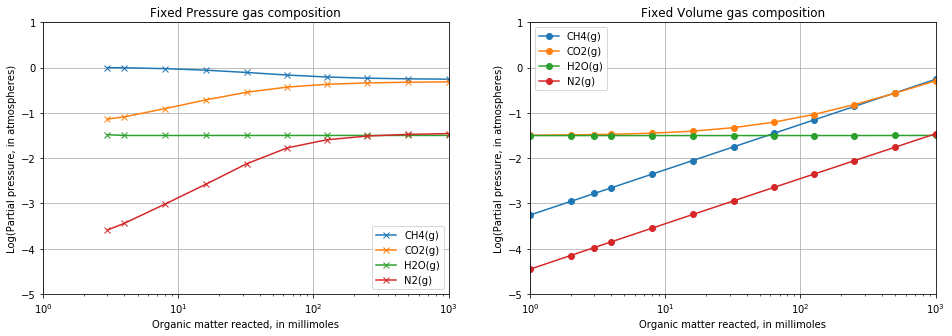

In [41]:
fig = plt.figure(figsize=[16,5])

# plot fixed pressure gas composition
fig.add_subplot(1,2,1)
pd.DataFrame(fp_frac, index=mmol).apply(np.log10)[2:].plot(style='-x', ax=plt.gca())
plt.title('Fixed Pressure gas composition')
plt.xscale('log')
plt.ylim([-5,1])
plt.grid()
plt.xlim(1e0, 1e3)
plt.xlabel('Organic matter reacted, in millimoles')
plt.ylabel('Log(Partial pressure, in atmospheres)')

# plot fixed volume gas composition
fig.add_subplot(1,2,2)
pd.DataFrame(fv_frac, index=mmol).apply(np.log10).plot(style='-o', ax=plt.gca())
plt.title('Fixed Volume gas composition')
plt.xscale('log')
plt.xlabel('Organic matter reacted, in millimoles')
plt.ylabel('Log(Partial pressure, in atmospheres)')
plt.grid()
plt.ylim([-5,1])
